In [107]:
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("../..")


from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap


In [108]:
#import the data
org = torch.load("../../originals.pt")
aug = torch.load("../../augmentations.pt")
labels = torch.load("../../labels.pt")
norm_org = org/org.norm(dim=1,keepdim=True)
aug_norm = aug/aug.norm(dim=-1,keepdim=True)

In [109]:
import umap
reducer = umap.UMAP(n_components=2,random_state=42)
reducer.fit(norm_org)
emb = reducer.transform(norm_org)

/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### 1. compute Nearest Neighbours, and distances (K=20)

In [110]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=11,metric="cosine")
knn.fit(norm_org)
distances,indices = knn.kneighbors(norm_org)
distances = distances[:,1:]
indices = indices[:,1:]

In [111]:
distances = torch.from_numpy(distances)
indices = torch.from_numpy(indices)


In [112]:
def compute_sigma(distances,rhos,n_iter = 64,tol = 1e-5):
    """
    Computes sigma for each point via a vectorized binary search.

    This function finds a sigma for each row in the distances matrix,
    such that the sum of the kernel probabilities equals log2(k).

    Args:
        distances: A tensor of shape (N, k) of sorted distances to nearest neighbors.
        rhos: A tensor of shape (N,) with the distance to the first nearest neighbor.
        k: The number of neighbors.
        n_iter: The number of iterations for the binary search.
        tol: A small tolerance value.

    Returns:
        A tensor of shape (N,) containing the computed sigma for each point.
    """
    N,k = distances.shape

    target = torch.log2(torch.tensor(k, device=distances.device, dtype=torch.float32))
    
    # Initialize search bounds
    # Use unsqueeze to make rhos (N, 1) for broadcasting with distances (N, k)
    d_minus_rho = distances - rhos.unsqueeze(1)
    d_minus_rho.clamp_(min=0.) # Equivalent to max(0, d - rho)

    lower_bound = torch.zeros(distances.shape[0], device=distances.device)
    upper_bound = torch.full((distances.shape[0],), float('inf'), device=distances.device)
    
    # A smart initial guess for the upper bound
    # If sigma is large, exp term -> 1, sum -> k. If small, exp -> 0, sum -> 0.
    # We can find a sigma that is guaranteed to be an upper bound.
    # For simplicity, many implementations start high or use a heuristic.
    # Here we check where the sum of distances is non-zero to avoid div by zero.
    mid_sigma = torch.ones(distances.shape[0], device=distances.device)

    # Vectorized binary search
    for i in range(n_iter):
        # Calculate kernel probabilities with current sigma guesses
        # Use unsqueeze to make mid_sigma (N, 1) for broadcasting
        vals = -d_minus_rho / mid_sigma.unsqueeze(1)
        p_sum = torch.exp(vals).sum(dim=1)

        # Update bounds based on whether the sum is too high or too low
        is_less = p_sum < target
        lower_bound[is_less] = mid_sigma[is_less]
        upper_bound[~is_less] = mid_sigma[~is_less]
        
        # Update sigma for the next iteration
        mid_sigma = (lower_bound + upper_bound) / 2.0

        # Handle cases where upper_bound is infinite (initial state)
        inf_mask = torch.isinf(upper_bound)
        mid_sigma[inf_mask] = lower_bound[inf_mask] * 2

        # Check for convergence
        if torch.max(torch.abs(p_sum - target)) < tol:
            break
            
    # If any sigmas are still 0, it means the distances were likely all 0.
    # Set them to a small value to avoid division by zero later.
    mid_sigma[mid_sigma == 0.0] = torch.finfo(torch.float32).eps
    
    return mid_sigma

rho = distances[:,0]
sigma = compute_sigma(distances,rho,11)


<Axes: ylabel='Count'>

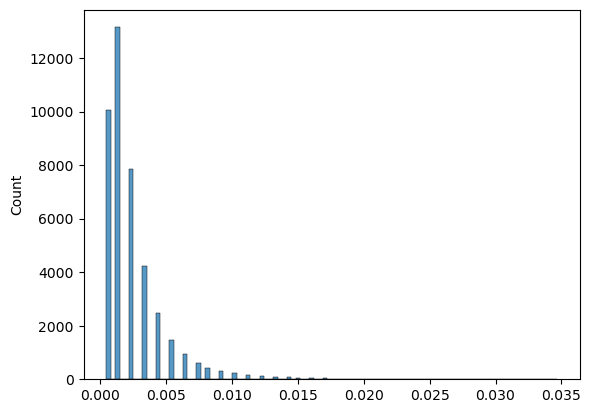

In [113]:
sns.histplot(sigma.numpy(),bins=100)

### Compute edge weights of the Graph W (N,K)

In [ ]:
def compute_directed_weights(distances, rhos, sigmas):
    # Computes the directed edge weights w_j|i
    
    # Expand rhos and sigmas for broadcasting
    rhos_expanded = rhos.unsqueeze(1)
    sigmas_expanded = sigmas.unsqueeze(1)
    
    # Ensure sigma is not zero to avoid division by zero
    sigmas_expanded[sigmas_expanded == 0.0] = torch.finfo(torch.float32).eps

    # d(xi, xj) - rho_i
    d_minus_rho = distances - rhos_expanded
    
    # max(0, d - rho)
    d_minus_rho.clamp_(min=0.)
    
    # exp(-max(0, d - rho) / sigma)
    weights = torch.exp(-d_minus_rho / sigmas_expanded)
    
    return weights


def symmetrize_graph(knn_indices, knn_weights, n_points):
    # Symmetrizes the graph to create the final weight matrix W
    
    rows = torch.arange(n_points, device=knn_indices.device).repeat_interleave(knn_indices.shape[1])
    cols = knn_indices.flatten()
    vals = knn_weights.flatten()
    
    # Create the directed sparse graph W_directed
    W_directed = torch.sparse_coo_tensor(
        torch.stack([rows, cols]),
        vals,
        size=(n_points, n_points)
    )
    
    # Symmetrize using W = w + w.T - w * w.T
    W_transpose = W_directed.t()
    
    # Element-wise multiplication for sparse tensors
    hadamard_prod = W_directed * W_transpose
    
    W_symmetric = W_directed + W_transpose - hadamard_prod
    
    return W_symmetric

    
W  = compute_directed_weights(distances,rho,sigma)

W = symmetrize_graph(indices,W,W.shape[0])




### Initialize the embedding 

In [ ]:
def initialize_embedding(n_points, n_components=2, device='cuda'):
    # Creates an initial random layout for the N points.
    embedding = torch.rand(n_points, n_components, device=device) * 20.0 - 10.0
    return embedding

embedding = initialize_embedding(W.shape[0])

### Curve fitting for a,b parameters - approximations of "min_dist" and "spread"

1.5769434601962196 0.8950608779914887


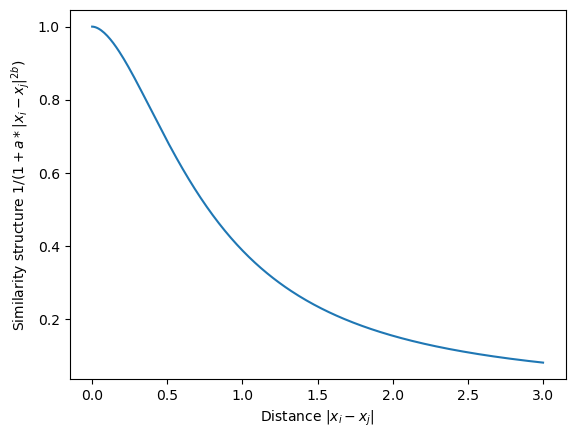

In [ ]:
from scipy.optimize import curve_fit
def find_ab_params(spread=1.0, min_dist=0.1):
    # Finds the parameters 'a' and 'b' for the low-dimensional curve
    # by fitting to a target curve defined by spread and min_dist.
    
    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros_like(xv)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    
    params, cov = curve_fit(curve, xv, yv)
    a, b = params[0], params[1]
    
    return a, b

a,b = find_ab_params(spread=1.0, min_dist=0.1)
print(a,b)
xv = np.linspace(0, 3, 300)
yv = 1.0 / (1.0 + a * xv ** (2 * b))
plt.plot(xv, yv)
plt.xlabel("Distance $|x_i - x_j|$")
plt.ylabel("Similarity structure $1/ (1 + a * |x_i - x_j|^{2b})$")
plt.show()




### Write the UMAP Loss function

In [ ]:
def umap_loss_fn(embedding, pos_head, pos_tail, n_neg_samples, n_points, a, b):

    pos_head_vecs = embedding[pos_head]
    pos_tail_vecs = embedding[pos_tail]
    dist_sq_pos = torch.sum((pos_head_vecs - pos_tail_vecs) ** 2, dim=1).clamp_(min=1e-8)
    p_pos = 1.0 / (1.0 + a * dist_sq_pos ** b)
    attractive_loss = -torch.log(p_pos)

    neg_head_vecs = pos_head_vecs.repeat_interleave(n_neg_samples, dim=0)
    neg_tail_indices = torch.randint(0, n_points, (len(pos_head_vecs) * n_neg_samples,), device=embedding.device)
    neg_tail_vecs = embedding[neg_tail_indices]
    dist_sq_neg = torch.sum((neg_head_vecs - neg_tail_vecs) ** 2, dim=1).clamp_(min=1e-8)
    p_neg = 1.0 / (1.0 + a * dist_sq_neg ** b)
    repulsive_loss = -torch.log(1.0 - p_neg + 1e-8)
    
    return (attractive_loss.mean() + repulsive_loss.mean()) / 2.0


In [ ]:
# Initialize embedding
device = "cuda"
n_neg_samples = 5
n_points = W.shape[0]
embedding = (torch.rand(W.shape[0], 2, device=device) * 20.0 - 10.0).requires_grad_(True)
optimizer = torch.optim.Adam([embedding], lr=1)

# Get edges and weights for sampling
heads = W.coalesce().indices()[0]
tails = W.coalesce().indices()[1]
weights = W.coalesce().values()
weights_normalized = weights / torch.sum(weights)

print("Optimizing low-dimensional embedding...")
for epoch in range(1000):
    # Sample positive edges
    positive_edge_indices = torch.multinomial(weights_normalized, len(weights), replacement=True)
    pos_head = heads[positive_edge_indices]
    pos_tail = tails[positive_edge_indices]

    loss = umap_loss_fn(embedding, pos_head, pos_tail, n_neg_samples, n_points, a, b)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")




Optimizing low-dimensional embedding...
Epoch 0, Loss: 2.2177
Epoch 100, Loss: 0.1455
Epoch 200, Loss: 0.1264
Epoch 300, Loss: 0.1231
Epoch 400, Loss: 0.1225


KeyboardInterrupt: 

<Axes: >

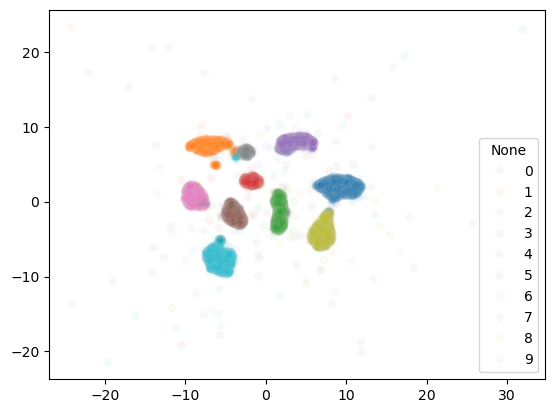

In [ ]:
sns.scatterplot(x = emb[:,0],
                y = emb[:,1],
                hue = labels,
                palette="tab10",alpha=0.05)

In [63]:

def umap_cluster_fn(dist_head, dist_tail, num_neg_samples=5, tau=0.1,lamb=1):
    """
    Calculates a UMAP-inspired loss.

    Args:
        dist_head (torch.Tensor): Output tensor from one branch of a model.
        dist_tail (torch.Tensor): Output tensor from another branch of a model.
        num_neg_samples (int): Not used in this implementation, but kept for signature consistency.
        tau (float): Weight for the repulsive force.

    Returns:
        torch.Tensor: The computed loss value.
    """
    pos_head_vecs = F.softmax(dist_head, dim=1)
    pos_tail_vecs = F.softmax(dist_tail, dim=1)

    sim = pos_head_vecs @ pos_tail_vecs.T

    # Attractive force is calculated from the diagonal elements
    P = torch.diag(sim)

    # To calculate repulsive force, clone `sim` to not interfere with the autograd graph
    Q = sim.clone()
    Q.fill_diagonal_(0) # Zero out the diagonal for the repulsive term calculation
    #randomly select 10 rows 
    Q = Q[torch.randperm(Q.shape[0])[:num_neg_samples]]
    attractive_loss = -torch.log(P + 1e-8)
    repulsive_force = -torch.log((1 - Q) + 1e-8)

    #add an entropy term
    D = pos_head_vecs.mean(dim=0)
    entropy = torch.sum(D*torch.log(D+1e-8)) / torch.log(torch.tensor(pos_head_vecs.shape[1]))


    return attractive_loss.mean(),repulsive_force.mean() * tau,lamb * entropy 

In [64]:
class Classifier(nn.Module):
    def __init__(self,K=10,input_dim=512,hidden_dim=1024):
        super(Classifier,self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,K)
        )

    def forward(self,x):
        return self.classifier(x)
    


KeyboardInterrupt: 

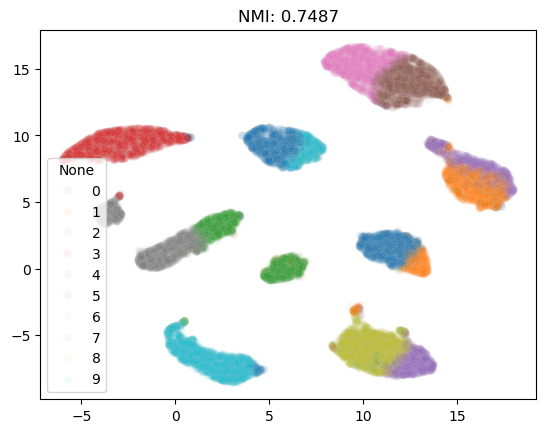

In [88]:
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, TensorDataset
f,a = plt.subplots(1,1)
# Initialize embedding
device = "cuda"
n_neg_samples = 5
n_points = W.shape[0]
#distribution = (torch.rand(W.shape[0], 2, device=device)).requires_grad_(True)
model = Classifier()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Get edges and weights for sampling
heads = W.coalesce().indices()[0]
tails = W.coalesce().indices()[1]
weights = W.coalesce().values()
weights_normalized = weights / torch.sum(weights)

print("Optimizing low-dimensional distribution...")
losses = []
nmi_scores = []
att_losses = []
rep_losses = []
ent_losses = []
for epoch in range(100):

    # Sample positive edges
    positive_edge_indices = torch.multinomial(weights_normalized, len(weights), replacement=True)
    pos_head = heads[positive_edge_indices]
    pos_tail = tails[positive_edge_indices]
    dataset = TensorDataset(pos_head,pos_tail)
    dataloader = DataLoader(dataset,batch_size=1000,shuffle=True)
    
    
    for i,batch in enumerate(dataloader):
        p_head,p_tail = batch[0],batch[1]
        head_repr,tail_repr = org[p_head].to(device),org[p_tail].to(device)
        dist_head,dist_tail = model(head_repr),model(tail_repr)
        optimizer.zero_grad()
        att,rep,ent = umap_cluster_fn(dist_head,dist_tail,tau=2.0,lamb=1.0,num_neg_samples=20)
        loss = att + rep + ent
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        att_losses.append(att.item())
        rep_losses.append(rep.item())
        ent_losses.append(ent.item())
        if i >5:
            break

    with torch.no_grad():
        predictions = model(org.to(device)).cpu().argmax(dim=1)
    nmi_score = nmi(predictions.numpy(),labels.numpy())
    clear_output(wait=True)
    a.clear()
    a.set_title(f"NMI: {nmi_score:.4f}")
    sns.scatterplot(x=emb[:,0],
                y=emb[:,1],
                hue=predictions,
                palette="tab10",alpha=0.05)
    display(f)

In [153]:
def alex_cluster_loss(p1,p2,sigma,tau):

    p1 = p1.softmax(dim=1)
    p2 = p2.softmax(dim=1)
    
    sim = p1 @ p2.T
    P = torch.diag(sim)
    attractive_force = -torch.log(P + 1e-8) * sigma

    Q = sim.clone()
    Q.fill_diagonal_(0)
    repulsive_force = -torch.log((1 - Q) + 1e-8) 

    D = p1.mean(dim=0)
    entropy = torch.sum(D*torch.log(D+1e-8)) / torch.log(torch.tensor(p1.shape[1]))
    
    return attractive_force.mean(),repulsive_force.mean() * tau,entropy


In [154]:
sigma_norm = sigma / sigma.mean()

In [155]:
sigma_norm.shape

torch.Size([42443])

In [159]:
dataset = TensorDataset(org,indices,sigma_norm)
dataloader = DataLoader(dataset,batch_size=1000,shuffle=True)
model = Classifier()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
att_losses = []
rep_losses = []
progress_bar = tqdm.tqdm(range(10))
for epoch in progress_bar:
    
    for i,batch in enumerate(dataloader):
        
        x1 = batch[0].to(device)
        x2 = org[batch[1][:,torch.randperm(10)[0]]].to(device)
        sig = batch[2].to(device)
        p1,p2 = model(x1),model(x2)
        att,rep,ent = alex_cluster_loss(p1,p2,sig,tau=1.0)
        loss = att + rep + ent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        att_losses.append(att.item())
        

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


In [160]:
indices.shape

torch.Size([42443, 10])

<Axes: title={'center': 'NMI: 0.8779'}>

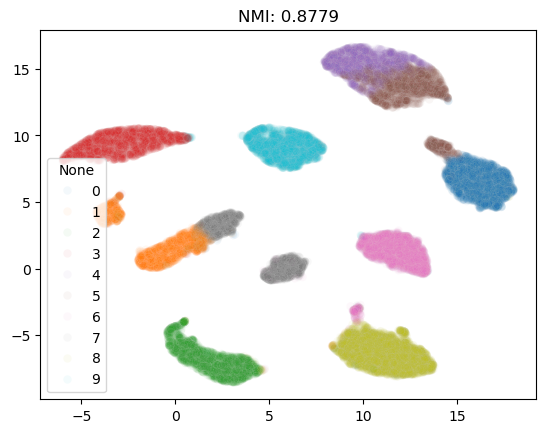

In [161]:

with torch.no_grad():
    predictions = model(org.to(device)).cpu().argmax(dim=1)
nmi_score = nmi(predictions.numpy(),labels.numpy())
f,a = plt.subplots(1,1)
a.clear()
a.set_title(f"NMI: {nmi_score:.4f}")
sns.scatterplot(x=emb[:,0],
            y=emb[:,1],
            hue=predictions,
            palette="tab10",alpha=0.05)


In [ ]:
with torch.no_grad():
    predictions = model(org.to(device)).cpu().argmax(dim=1).numpy()

<Axes: >

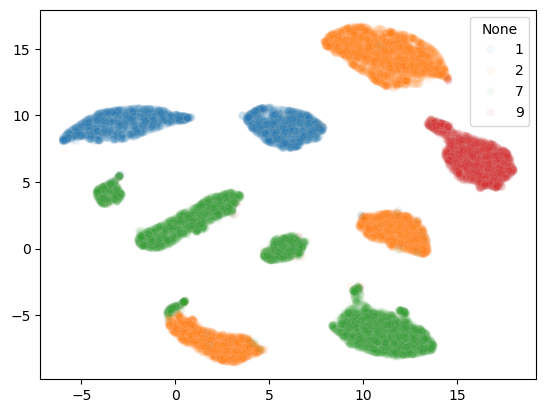

In [ ]:
sns.scatterplot(x=emb[:,0],
                y=emb[:,1],
                hue=predictions,
                palette="tab10",alpha=0.05)